<a href="https://colab.research.google.com/github/jmbaek/proteinBERT/blob/main/ProteinBERT_benchmarks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**1. Check the GPU device**


In [ ]:
!nvidia-smi

Wed Mar 30 12:26:23 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [1]:
!wget ftp://ftp.cs.huji.ac.il/users/nadavb/protein_bert/protein_benchmarks/signal* -P /content/protein_data/

--2022-03-31 11:00:12--  ftp://ftp.cs.huji.ac.il/users/nadavb/protein_bert/protein_benchmarks/*
           => ‘/content/protein_data/.listing’
Resolving ftp.cs.huji.ac.il (ftp.cs.huji.ac.il)... 132.65.116.15
Connecting to ftp.cs.huji.ac.il (ftp.cs.huji.ac.il)|132.65.116.15|:21... connected.
Logging in as anonymous ... Logged in!
==> SYST ... done.    ==> PWD ... done.
==> TYPE I ... done.  ==> CWD (1) /users/nadavb/protein_bert/protein_benchmarks ... done.
==> PASV ... done.    ==> LIST ... done.

.listing                [ <=>                ]   2.15K  --.-KB/s    in 0.03s   

2022-03-31 11:00:15 (77.9 KB/s) - ‘/content/protein_data/.listing’ saved [2197]

Removed ‘/content/protein_data/.listing’.
--2022-03-31 11:00:15--  ftp://ftp.cs.huji.ac.il/users/nadavb/protein_bert/protein_benchmarks/PhosphositePTM.test.csv
           => ‘/content/protein_data/PhosphositePTM.test.csv’
==> CWD not required.
==> PASV ... done.    ==> RETR PhosphositePTM.test.csv ... done.
Length: 10368100 (9.9M)

P

## Setup

In [2]:
!git clone https://github.com/nadavbra/protein_bert.git
!git clone https://github.com/nadavbra/shared_utils.git
!cp -R protein_bert/proteinbert/ /usr/lib/python3.7/proteinbert/
!cp -R shared_utils/ /usr/lib/python3.7/proteinbert/

Cloning into 'protein_bert'...
remote: Enumerating objects: 128, done.
remote: Counting objects: 100% (128/128), done.
remote: Compressing objects: 100% (103/103), done.
remote: Total 128 (delta 66), reused 55 (delta 22), pack-reused 0
Receiving objects: 100% (128/128), 8.68 MiB | 12.72 MiB/s, done.
Resolving deltas: 100% (66/66), done.
Cloning into 'shared_utils'...
remote: Enumerating objects: 48, done.
remote: Counting objects: 100% (48/48), done.
remote: Compressing objects: 100% (31/31), done.
remote: Total 48 (delta 26), reused 37 (delta 15), pack-reused 0
Unpacking objects: 100% (48/48), done.


In [3]:
BENCHMARKS_DIR = '/content/protein_data/'
!mkdir -p /root/proteinbert_models/

## Fine-tune model for signal peptide


In [9]:
import os

import pandas as pd
from IPython.display import display
from tensorflow import keras
from sklearn.model_selection import train_test_split

from proteinbert import OutputType, OutputSpec, FinetuningModelGenerator, load_pretrained_model, finetune, evaluate_by_len
from proteinbert.conv_and_global_attention_model import get_model_with_hidden_layers_as_outputs

BENCHMARK_NAME = 'signalP_binary'

# A local (non-global) bianry output
OUTPUT_TYPE = OutputType(False, 'binary')
UNIQUE_LABELS = [0, 1]
OUTPUT_SPEC = OutputSpec(OUTPUT_TYPE, UNIQUE_LABELS)

# Loading the dataset

train_set_file_path = os.path.join(BENCHMARKS_DIR, '%s.train.csv' % BENCHMARK_NAME)
train_set = pd.read_csv(train_set_file_path).dropna().drop_duplicates()
train_set, valid_set = train_test_split(train_set, stratify = train_set['label'], test_size = 0.1, random_state = 0)

test_set_file_path = os.path.join(BENCHMARKS_DIR, '%s.test.csv' % BENCHMARK_NAME)
test_set = pd.read_csv(test_set_file_path).dropna().drop_duplicates()

print(f'{len(train_set)} training set records, {len(valid_set)} validation set records, {len(test_set)} test set records.')

# Loading the pre-trained model and fine-tuning it on the loaded dataset

pretrained_model_generator, input_encoder = load_pretrained_model()

# get_model_with_hidden_layers_as_outputs gives the model output access to the hidden layers (on top of the output)
model_generator = FinetuningModelGenerator(pretrained_model_generator, OUTPUT_SPEC, pretraining_model_manipulation_function = \
        get_model_with_hidden_layers_as_outputs, dropout_rate = 0.5)

training_callbacks = [
    keras.callbacks.ReduceLROnPlateau(patience = 1, factor = 0.25, min_lr = 1e-05, verbose = 1),
    keras.callbacks.EarlyStopping(patience = 2, restore_best_weights = True),
]

finetune(model_generator, input_encoder, OUTPUT_SPEC, train_set['seq'], train_set['label'], valid_set['seq'], valid_set['label'], \
        seq_len = 512, batch_size = 32, max_epochs_per_stage = 40, lr = 1e-04, begin_with_frozen_pretrained_layers = True, \
        lr_with_frozen_pretrained_layers = 1e-02, n_final_epochs = 1, final_seq_len = 1024, final_lr = 1e-05, callbacks = training_callbacks)


# Evaluating the performance on the test-set

results, confusion_matrix = evaluate_by_len(model_generator, input_encoder, OUTPUT_SPEC, test_set['seq'], test_set['label'], \
        start_seq_len = 512, start_batch_size = 32)

print('Test-set performance:')
display(results)

print('Confusion matrix:')
display(confusion_matrix)

14945 training set records, 1661 validation set records, 4152 test set records.
[2022_03_31-11:10:07] Training set: Filtered out 0 of 14945 (0.0%) records of lengths exceeding 510.
[2022_03_31-11:10:08] Validation set: Filtered out 0 of 1661 (0.0%) records of lengths exceeding 510.
[2022_03_31-11:10:08] Training with frozen pretrained layers...


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/40
468/468 [==============================] - 37s 57ms/step - loss: 0.0962 - val_loss: 0.0658 - lr: 0.0100
Epoch 2/40
468/468 [==============================] - ETA: 0s - loss: 0.0731
Epoch 2: ReduceLROnPlateau reducing learning rate to 0.0024999999441206455.
468/468 [==============================] - 23s 49ms/step - loss: 0.0731 - val_loss: 0.0862 - lr: 0.0100
Epoch 3/40
468/468 [==============================] - 23s 49ms/step - loss: 0.0584 - val_loss: 0.0624 - lr: 0.0025
Epoch 4/40
468/468 [==============================] - 23s 49ms/step - loss: 0.0578 - val_loss: 0.0595 - lr: 0.0025
Epoch 5/40
467/468 [============================>.] - ETA: 0s - loss: 0.0547
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0006249999860301614.
468/468 [==============================] - 23s 49ms/step - loss: 0.0547 - val_loss: 0.0641 - lr: 0.0025
Epoch 6/40
467/468 [============================>.] - ETA: 0s - loss: 0.0529
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.000156249

,# records,AUC
Model seq len,,
512,4152,0.995517
All,4152,0.995517


Confusion matrix:


,0,1
0,3446,32
1,33,641


## Run benchmarks

In [12]:
import os

import pandas as pd
from IPython.display import display
from tensorflow import keras
from sklearn.model_selection import train_test_split

from proteinbert import OutputType, OutputSpec, FinetuningModelGenerator, load_pretrained_model, finetune, evaluate_by_len, log
from proteinbert.conv_and_global_attention_model import get_model_with_hidden_layers_as_outputs

BENCHMARKS = [
    # name, output_type
    ('signalP_binary', OutputType(False, 'binary')),
    #('scop', OutputType(False, 'categorical')),
    #('secondary_structure', OutputType(True, 'categorical')),
]

settings = {
    'max_dataset_size': None,
    'max_epochs_per_stage': 40,
    'seq_len': 512,
    'batch_size': 32,
    'final_epoch_seq_len': 1024,
    'initial_lr_with_frozen_pretrained_layers': 1e-02,
    'initial_lr_with_all_layers': 1e-04,
    'final_epoch_lr': 1e-05,
    'dropout_rate': 0.5,
    'training_callbacks': [
        keras.callbacks.ReduceLROnPlateau(patience = 1, factor = 0.25, min_lr = 1e-05, verbose = 1),
        keras.callbacks.EarlyStopping(patience = 2, restore_best_weights = True),
    ],
}

####### Uncomment for debug mode
# settings['max_dataset_size'] = 500
# settings['max_epochs_per_stage'] = 1

def run_benchmark(benchmark_name, pretraining_model_generator, input_encoder, pretraining_model_manipulation_function = None):
    
    log('========== %s ==========' % benchmark_name)  
    
    output_type = get_benchmark_output_type(benchmark_name)
    log('Output type: %s' % output_type)
    
    train_set, valid_set, test_set = load_benchmark_dataset(benchmark_name)        
    log(f'{len(train_set)} training set records, {len(valid_set)} validation set records, {len(test_set)} test set records.')
    
    if settings['max_dataset_size'] is not None:
        log('Limiting the training, validation and test sets to %d records each.' % settings['max_dataset_size'])
        train_set = train_set.sample(min(settings['max_dataset_size'], len(train_set)), random_state = 0)
        valid_set = valid_set.sample(min(settings['max_dataset_size'], len(valid_set)), random_state = 0)
        test_set = test_set.sample(min(settings['max_dataset_size'], len(test_set)), random_state = 0)
    
    if output_type.is_seq or output_type.is_categorical:
        train_set['label'] = train_set['label'].astype(str)
        valid_set['label'] = valid_set['label'].astype(str)
        test_set['label'] = test_set['label'].astype(str)
    else:
        train_set['label'] = train_set['label'].astype(float)
        valid_set['label'] = valid_set['label'].astype(float)
        test_set['label'] = test_set['label'].astype(float)
        
    if output_type.is_categorical:
        
        if output_type.is_seq:
            unique_labels = sorted(set.union(*train_set['label'].apply(set)) | set.union(*valid_set['label'].apply(set)) | \
                    set.union(*test_set['label'].apply(set)))
        else:
            unique_labels = sorted(set(train_set['label'].unique()) | set(valid_set['label'].unique()) | set(test_set['label'].unique()))
            
        log('%d unique lebels.' % len(unique_labels))
    elif output_type.is_binary:
        unique_labels = [0, 1]
    else:
        unique_labels = None
        
    output_spec = OutputSpec(output_type, unique_labels)
    model_generator = FinetuningModelGenerator(pretraining_model_generator, output_spec, pretraining_model_manipulation_function = \
            pretraining_model_manipulation_function, dropout_rate = settings['dropout_rate'])
    finetune(model_generator, input_encoder, output_spec, train_set['seq'], train_set['label'], valid_set['seq'], valid_set['label'], \
            seq_len = settings['seq_len'], batch_size = settings['batch_size'], max_epochs_per_stage = settings['max_epochs_per_stage'], \
            lr = settings['initial_lr_with_all_layers'], begin_with_frozen_pretrained_layers = True, lr_with_frozen_pretrained_layers = \
            settings['initial_lr_with_frozen_pretrained_layers'], n_final_epochs = 1, final_seq_len = settings['final_epoch_seq_len'], \
            final_lr = settings['final_epoch_lr'], callbacks = settings['training_callbacks'])
    
    for dataset_name, dataset in [('Training-set', train_set), ('Validation-set', valid_set), ('Test-set', test_set)]:
        
        log('*** %s performance: ***' % dataset_name)
        results, confusion_matrix = evaluate_by_len(model_generator, input_encoder, output_spec, dataset['seq'], dataset['label'], \
                start_seq_len = settings['seq_len'], start_batch_size = settings['batch_size'])
    
        with pd.option_context('display.max_rows', None, 'display.max_columns', None):
            display(results)
        
        if confusion_matrix is not None:
            with pd.option_context('display.max_rows', 16, 'display.max_columns', 10):
                log('Confusion matrix:')
                display(confusion_matrix)
                
    return model_generator

def load_benchmark_dataset(benchmark_name):
    
    train_set_file_path = os.path.join(BENCHMARKS_DIR, '%s.train.csv' % benchmark_name)
    valid_set_file_path = os.path.join(BENCHMARKS_DIR, '%s.valid.csv' % benchmark_name)
    test_set_file_path = os.path.join(BENCHMARKS_DIR, '%s.test.csv' % benchmark_name)
    
    train_set = pd.read_csv(train_set_file_path).dropna().drop_duplicates()
    test_set = pd.read_csv(test_set_file_path).dropna().drop_duplicates()
          
    if os.path.exists(valid_set_file_path):
        valid_set = pd.read_csv(valid_set_file_path).dropna().drop_duplicates()
    else:
        log(f'Validation set {valid_set_file_path} missing. Splitting training set instead.')
        train_set, valid_set = train_test_split(train_set, stratify = train_set['label'], test_size = 0.1, random_state = 0)
    
    return train_set, valid_set, test_set

def get_benchmark_output_type(benchmark_name):
    for name, output_type in BENCHMARKS:
        if name == benchmark_name:
            return output_type
        
pretrained_model_generator, input_encoder = load_pretrained_model()

for benchmark_name, _ in BENCHMARKS:
    run_benchmark(benchmark_name, pretrained_model_generator, input_encoder, pretraining_model_manipulation_function = \
            get_model_with_hidden_layers_as_outputs)
        
log('Done.')

[2022_03_31-12:05:29] ========== signalP_binary ==========
[2022_03_31-12:05:29] Output type: global binary
[2022_03_31-12:05:29] Validation set /content/protein_data/signalP_binary.valid.csv missing. Splitting training set instead.
[2022_03_31-12:05:29] 14945 training set records, 1661 validation set records, 4152 test set records.
[2022_03_31-12:05:29] Training set: Filtered out 0 of 14945 (0.0%) records of lengths exceeding 510.
[2022_03_31-12:05:29] Validation set: Filtered out 0 of 1661 (0.0%) records of lengths exceeding 510.
[2022_03_31-12:05:29] Training with frozen pretrained layers...


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/40
468/468 [==============================] - 36s 55ms/step - loss: 0.0962 - val_loss: 0.0660 - lr: 0.0100
Epoch 2/40
468/468 [==============================] - 23s 49ms/step - loss: 0.0688 - val_loss: 0.0629 - lr: 0.0100
Epoch 3/40
467/468 [============================>.] - ETA: 0s - loss: 0.0727
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0024999999441206455.
468/468 [==============================] - 23s 49ms/step - loss: 0.0727 - val_loss: 0.0702 - lr: 0.0100
Epoch 4/40
468/468 [==============================] - 23s 49ms/step - loss: 0.0599 - val_loss: 0.0606 - lr: 0.0025
Epoch 5/40
468/468 [==============================] - 23s 49ms/step - loss: 0.0554 - val_loss: 0.0599 - lr: 0.0025
Epoch 6/40
468/468 [==============================] - 23s 49ms/step - loss: 0.0547 - val_loss: 0.0584 - lr: 0.0025
Epoch 7/40
468/468 [==============================] - 23s 49ms/step - loss: 0.0538 - val_loss: 0.0574 - lr: 0.0025
Epoch 8/40
467/468 [============================>.] -

,# records,AUC
Model seq len,,
512,14945,0.999663
All,14945,0.999663


[2022_03_31-12:16:31] Confusion matrix:


,0,1
0,12457,60
1,25,2403


[2022_03_31-12:16:31] *** Validation-set performance: ***


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


,# records,AUC
Model seq len,,
512,1661,0.993136
All,1661,0.993136


[2022_03_31-12:16:37] Confusion matrix:


,0,1
0,1374,17
1,5,265


[2022_03_31-12:16:37] *** Test-set performance: ***


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


,# records,AUC
Model seq len,,
512,4152,0.996171
All,4152,0.996171


[2022_03_31-12:16:47] Confusion matrix:


,0,1
0,3434,44
1,29,645


[2022_03_31-12:16:47] Done.
Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.



## Visualizing the attention layers

You can run this only after you have fine-tuned the model on a benchmark (e.g. signal peptide) and obtained model_generator.


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


MLGMIRNSLFGSVETWPWQVLSTGGKEDVSYEERACEGGKFATVEVTDKPVDEALREAMPKIMKYVGGTN 0


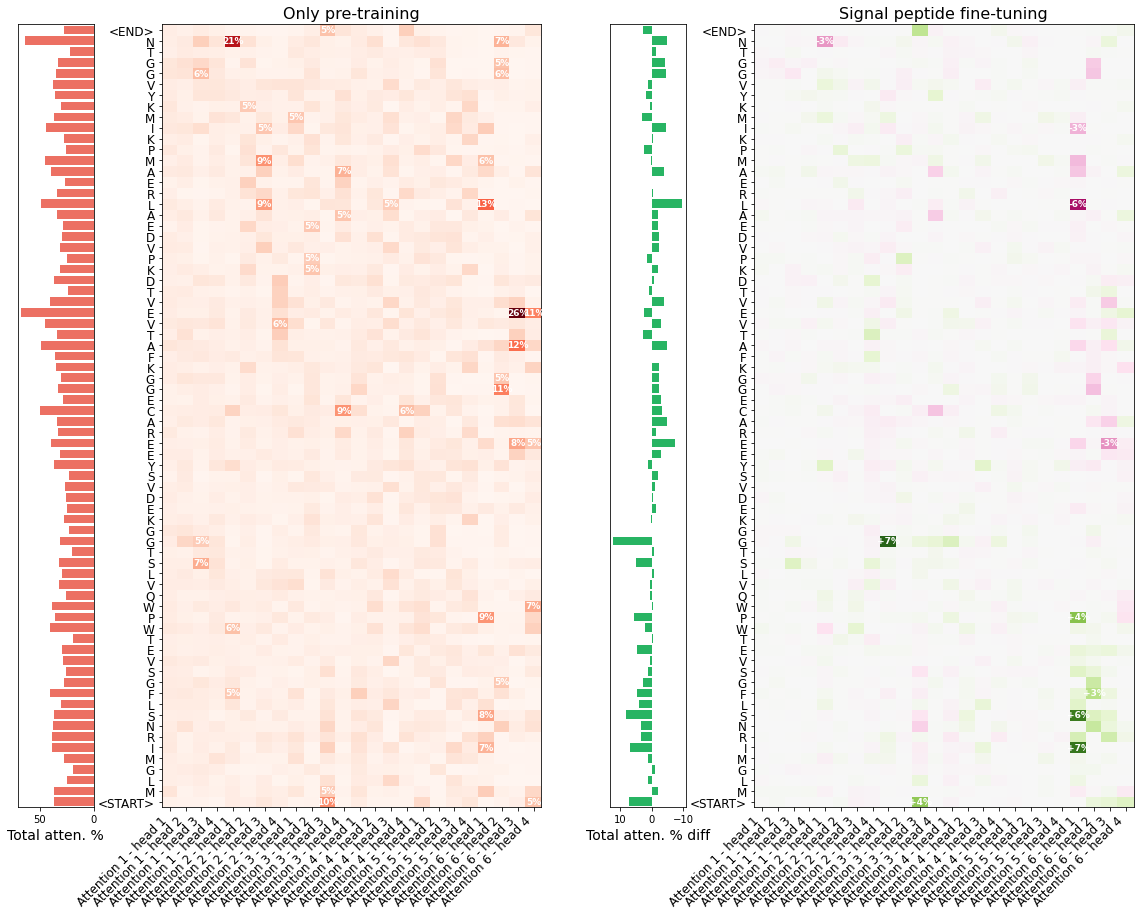

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

BENCHMARK_DISPLAY_NAME = 'Signal peptide'

TEST_SET_FILE_PATH = 'protein_data/signalP_binary.train.csv'
IDEAL_LEN = 80

def calculate_attentions(model, input_encoder, seq, seq_len = None):
    
    from tensorflow.keras import backend as K
    from proteinbert.tokenization import index_to_token
    
    if seq_len is None:
        seq_len = len(seq) + 2
    
    X = input_encoder.encode_X([seq], seq_len)
    (X_seq,), _ = X
    seq_tokens = list(map(index_to_token.get, X_seq))

    model_inputs = [layer.input for layer in model.layers if 'InputLayer' in str(type(layer))][::-1]
    model_attentions = [layer.calculate_attention(layer.input) for layer in model.layers if 'GlobalAttention' in str(type(layer))]
    invoke_model_attentions = K.function(model_inputs, model_attentions)
    attention_values = invoke_model_attentions(X)
    
    attention_labels = []
    merged_attention_values = []

    for attention_layer_index, attention_layer_values in enumerate(attention_values):
        for head_index, head_values in enumerate(attention_layer_values):
            attention_labels.append('Attention %d - head %d' % (attention_layer_index + 1, head_index + 1))
            merged_attention_values.append(head_values)

    attention_values = np.array(merged_attention_values)
    
    return attention_values, seq_tokens, attention_labels

def plot_attention(attention_values, seq_tokens, attention_labels, ax, cmap = 'Reds', vmin = 0, vmax = None, text_value_threshold = 0.1):

    heatmap = ax.pcolor(attention_values.transpose(), cmap = cmap, vmin = vmin, vmax = vmax)

    ax.set_xticks(np.arange(len(attention_labels)) + 0.5)
    ax.set_xticklabels(attention_labels, rotation = 45, ha = 'right', fontsize = 12)
    ax.set_yticks(np.arange(len(seq_tokens)) + 0.5)
    ax.set_yticklabels(seq_tokens, fontsize = 12)

    for i, row in enumerate(attention_values):
        for j, value in enumerate(row):
            if abs(value) >= text_value_threshold:
                add_plus_sign = attention_values.min() < 0 and value > 0
                plus_sign = '+' if add_plus_sign else ''
                ax.text(i + 0.5, j + 0.5, plus_sign + '%d%%' % (100 * value), color = 'white', ha = 'center', va = 'center', \
                        fontsize = 9, fontweight = 'bold', fontstretch = 'condensed')
                
test_set = pd.read_csv(TEST_SET_FILE_PATH)
chosen_index = ((test_set['seq'].str.len() - IDEAL_LEN).abs()).sort_values().index[0]
seq = test_set.loc[chosen_index, 'seq']
label = test_set.loc[chosen_index, 'label']
                
seq_len = len(seq) + 2

pretrained_model_generator, input_encoder = load_pretrained_model()
model = pretrained_model_generator.create_model(seq_len)
pretrained_attention_values, pretrained_seq_tokens, pretrained_attention_labels = calculate_attentions(model, input_encoder, seq, \
        seq_len = seq_len)

model = model_generator.create_model(seq_len)
finetuned_attention_values, finetuned_seq_tokens, finetuned_attention_labels = calculate_attentions(model, input_encoder, seq, \
        seq_len = seq_len)
assert finetuned_seq_tokens == pretrained_seq_tokens
assert finetuned_attention_labels == pretrained_attention_labels[:len(finetuned_attention_labels)]

fig, axes = plt.subplots(ncols = 4, figsize = (20, 0.2 * seq_len), gridspec_kw = dict(width_ratios = [1, 5, 1, 5]))
fig.subplots_adjust(wspace = 0.3)

axes[0].barh(np.arange(seq_len), 100 * pretrained_attention_values.sum(axis = 0), color = '#EC7063')
axes[0].set_ylim((-0.5, seq_len - 0.5))
axes[0].set_yticks([])
axes[0].invert_xaxis()
axes[0].set_xlabel('Total atten. %', fontsize = 14)

vmax = pretrained_attention_values.max()
plot_attention(pretrained_attention_values, pretrained_seq_tokens, pretrained_attention_labels, axes[1], cmap = 'Reds', vmax = vmax, \
        text_value_threshold = 0.05)
axes[1].set_title('Only pre-training', fontsize = 16)

axes[2].barh(np.arange(seq_len), 100 * (finetuned_attention_values - pretrained_attention_values).sum(axis = 0), color = '#28B463')
axes[2].set_ylim((-0.5, seq_len - 0.5))
axes[2].set_yticks([])
axes[2].invert_xaxis()
axes[2].set_xlabel('Total atten. % diff', fontsize = 14)

attention_diff = finetuned_attention_values - pretrained_attention_values[:len(finetuned_attention_labels), :]
vmax = np.abs(attention_diff).max()
plot_attention(attention_diff, finetuned_seq_tokens, finetuned_attention_labels, axes[3], cmap = 'PiYG', vmin = -vmax, vmax = vmax, \
        text_value_threshold = 0.03)
axes[3].set_title('%s fine-tuning' % BENCHMARK_DISPLAY_NAME, fontsize = 16)

print(seq, label)